In [58]:
import numpy as np
import dask.dataframe as dd
import pandas as pd
import xarray as xr
from mlmicrophysics.data import subset_data_files_by_date
from mlmicrophysics.models import DenseNeuralNetwork, DenseGAN
from matplotlib.colors import LogNorm
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [11]:
def subset_data_files_by_date(csv_path, train_date_start, train_date_end, test_date_start,
                              test_date_end, validation_frequency=3):
    """
    For a large set of csv files, this sorts the files into training, validation and testing data.
    This way the full dataset does not have to be loaded and then broken into pieces.

    Args:
        csv_path:
        train_date_start:
        train_date_end:
        test_date_start:
        test_date_end:
        validation_frequency:

    Returns:

    """
    if train_date_start > train_date_end:
        raise ValueError("train_date_start should not be greater than train_date_end")
    if test_date_start > test_date_end:
        raise ValueError("test_date_start should not be greater than test_date_end")
    if train_date_end > test_date_start:
        raise ValueError("train and test date periods overlap.")
    csv_files = pd.Series(sorted(glob(csv_path + "*.csv")))
    file_times = csv_files.str.split("/").str[-1].str.split("_").str[-2].astype(int).values
    print(file_times)
    train_val_ind = np.where((file_times >= train_date_start) & (file_times <= train_date_end))[0]
    test_ind = np.where((file_times >= test_date_start) & (file_times <= test_date_end))[0]
    val_ind = train_val_ind[::validation_frequency]
    train_ind = np.isin(train_val_ind, val_ind, invert=True)
    train_files = csv_files.loc[train_ind]
    val_files = csv_files.loc[val_ind]
    test_files = csv_files.loc[test_ind]
    return train_files, val_files, test_files

In [12]:
csv_path = "/Users/dgagne/data/cam_mp_files_csv/"
train_files, val_files, test_files = subset_data_files_by_date(csv_path, 0, 364 * 24, 365 * 24, 365 * 24  * 2)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [13]:
train_data = pd.concat([pd.read_csv(tf) for tf in train_files], ignore_index=True)

In [14]:
val_data = pd.concat([pd.read_csv(vf) for vf in val_files], ignore_index=True)

In [25]:
for col in train_data:
    print(col)

Index
lat
lev
lon
P0
PS
depth
row
col
hyam
hybm
pressure
temperature
RHO_CLUBB_lev
QC_TAU_in
NC_TAU_in
QR_TAU_in
NR_TAU_in
prc_MG2
nprc1_MG2
nprc_MG2
pra_MG2
npra_MG2
nragg_MG2
qctend_MG2
qrtend_MG2
time


In [15]:
def log10_eps(x, eps=1e-20):
    return np.log10(np.maximum(x, eps))

def log10_neg(x, eps=1e-20):
    return np.log10(np.maximum(-x, eps))


In [16]:
input_transforms = [None] + [log10_eps] * 4
output_transforms = [log10_eps] * 5 + [log10_neg]

In [17]:
input_cols = ['RHO_CLUBB_lev', 'QC_TAU_in',
       'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in']
output_cols = ['prc_MG2', 'nprc1_MG2', 'nprc_MG2', 'pra_MG2', 'npra_MG2', 'nragg_MG2']

In [18]:
transformed_input_data = pd.DataFrame(columns=input_cols, index=train_data.index, dtype=np.float32)
transformed_output_data = pd.DataFrame(columns=output_cols, index=train_data.index, dtype=np.float32)
for c, col in enumerate(input_cols):
    if input_transforms[c] is None:
        transformed_input_data[col] = train_data[col]
    else:
        transformed_input_data[col] = input_transforms[c](train_data[col])
for c, col in enumerate(output_cols):
    if output_transforms[c] is None:
        transformed_output_data[col] = train_data[col]
    else:
        transformed_output_data[col] = output_transforms[c](train_data[col])

In [19]:
transformed_input_val_data = pd.DataFrame(columns=input_cols, index=val_data.index, dtype=np.float32)
transformed_output_val_data = pd.DataFrame(columns=output_cols, index=val_data.index, dtype=np.float32)
for c, col in enumerate(input_cols):
    if input_transforms[c] is None:
        transformed_input_val_data[col] = val_data[col]
    else:
        transformed_input_val_data[col] = input_transforms[c](val_data[col])
for c, col in enumerate(output_cols):
    if output_transforms[c] is None:
        transformed_output_val_data[col] = val_data[col]
    else:
        transformed_output_val_data[col] = output_transforms[c](val_data[col])

In [20]:
rs_in = MinMaxScaler(feature_range=(0, 1))
rs_out = MinMaxScaler(feature_range=(0, 1))
scaled_input_data = rs_in.fit_transform(transformed_input_data)
scaled_output_data = rs_out.fit_transform(transformed_output_data)

In [21]:
scaled_input_val_data = rs_in.transform(transformed_input_val_data)
scaled_output_val_data = rs_out.transform(transformed_output_val_data)

In [22]:
pf = PolynomialFeatures(include_bias=False)
poly_input_data = pf.fit_transform(scaled_input_data)

In [68]:
poly_input_data.shape

(7113818, 20)

In [23]:
poly_val_data = pf.transform(scaled_input_val_data)

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


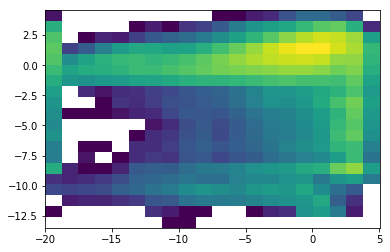

In [42]:
_ = plt.hist2d(transformed_output_data['nragg_MG2'], transformed_output_data["nprc1_MG2"], 
               bins=20, cmin=1, norm=LogNorm())

In [45]:
dnn = DenseNeuralNetwork(hidden_layers=3, hidden_neurons=50, inputs=20, outputs=6, activation="selu", 
                         verbose=1, batch_size=512, epochs=8, lr=0.001, use_dropout=True, 
                         output_activation="linear", dropout_alpha=0.3,optimizer="sgd", sgd_momentum=0.9,
                         decay=0.0001, l2_weight=0.00001, loss="mse")

In [85]:
dnn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
dense_141 (Dense)               (None, 40)           840         input_10[0][0]                   
__________________________________________________________________________________________________
activation_87 (Activation)      (None, 40)           0           dense_141[0][0]                  
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 40)           0           activation_87[0][0]              
__________________________________________________________________________________________________
dense_142 

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        5.00000e+00, 2.00000e+00, 6.00000e+00, 4.00000e+00, 1.40000e+01,
        1.60000e+01, 2.50000e+01, 2.70000e+01, 6.00000e+01, 7.80000e+01,
        1.07000e+02, 1.39000e+02, 2.00000e+02, 3.05000e+02, 3.86000e+02,
        6.24000e+02, 8.90000e+02, 1.06900e+03, 1.15700e+03, 1.23400e+03,
        1.22600e+03, 1.31800e+03, 1.40900e+03, 1.58900e+03, 1.79800e+03,
        2.14700e+03, 2.45000e+03, 2.86100e+03, 3.40500e+03, 3.95500e+03,
        4.62000e+03, 5.19800e+03, 6.08700e+03, 6.82900e+03, 8.56600e+03,
        9.25100e+03, 1.00810e+04, 1.15730e+04, 1.32040e+04, 1.43080e+04,
        1.61370e+04, 1.76470e+04, 1.99450e+04, 2.18530e+04, 2.39580e+04,
        2.62230e+04, 2.94420e+04, 3.20920e+04, 3.48630e+04, 3.78900e+04,
        4.17540e+04, 4.55410e+04, 4.97170e+04, 5.36540e+04, 5.75270e+04,
        6.26310e+04, 6.73090e+04, 7.18250e+04, 7.76570e+04, 8.22080e+04,
        8.82380e+04, 9.59890e+04, 1.01847e+05, 1.07

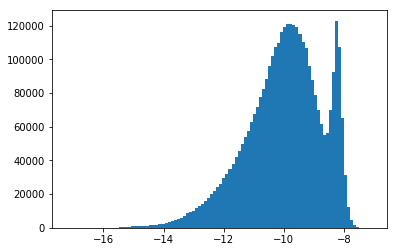

In [29]:
plt.hist(transformed_output_val_data.values[:, 0], bins=100)

In [46]:
dnn.fit(poly_input_data, [scaled_output_data[:, x] for x in range(scaled_output_data.shape[1])])

Epoch 1/8
7113818/7113818 [==============================] - 87s 12us/step - loss: 0.0597 - dense_35_loss: 0.0093 - dense_37_loss: 0.0127 - dense_39_loss: 0.0091 - dense_41_loss: 0.0080 - dense_43_loss: 0.0099 - dense_45_loss: 0.0065
Epoch 2/8
7113818/7113818 [==============================] - 84s 12us/step - loss: 0.0399 - dense_35_loss: 0.0057 - dense_37_loss: 0.0108 - dense_39_loss: 0.0060 - dense_41_loss: 0.0040 - dense_43_loss: 0.0066 - dense_45_loss: 0.0026
Epoch 3/8
7113818/7113818 [==============================] - 84s 12us/step - loss: 0.0375 - dense_35_loss: 0.0054 - dense_37_loss: 0.0104 - dense_39_loss: 0.0057 - dense_41_loss: 0.0035 - dense_43_loss: 0.0062 - dense_45_loss: 0.0022
Epoch 4/8
7113818/7113818 [==============================] - 85s 12us/step - loss: 0.0361 - dense_35_loss: 0.0052 - dense_37_loss: 0.0102 - dense_39_loss: 0.0054 - dense_41_loss: 0.0033 - dense_43_loss: 0.0060 - dense_45_loss: 0.0020
Epoch 5/8
7113818/7113818 [==============================] - 85s

In [47]:
val_preds = dnn.predict(poly_val_data)[:, :, 0].T
transformed_val_preds = rs_out.inverse_transform(val_preds)

In [228]:
scaled_output_val_data.max()

0.9717727790989179

In [22]:
val_preds.min(axis=0)

NameError: name 'val_preds' is not defined

In [36]:
dgan = DenseGAN(hidden_layers=4, hidden_neurons=80, inputs=5, outputs=6, use_noise=True, noise_sd=0.01,
                batch_size=1024, epochs=10, verbose=1, report_frequency=500)

In [37]:
dgan.fit(scaled_input_data, scaled_output_data)

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 000, Batch 0000, Step 000000, Disc Loss: 0.6895 Gen Loss: 0.8337
Epoch 000, Batch 0500, Step 000500, Disc Loss: 0.6006 Gen Loss: 1.2242
Epoch 000, Batch 1000, Step 001000, Disc Loss: 0.6650 Gen Loss: 0.8397
Epoch 000, Batch 1500, Step 001500, Disc Loss: 0.6863 Gen Loss: 0.6654
Epoch 000, Batch 2000, Step 002000, Disc Loss: 0.6888 Gen Loss: 0.7045
Epoch 000, Batch 2500, Step 002500, Disc Loss: 0.6982 Gen Loss: 0.6756
Epoch 000, Batch 3000, Step 003000, Disc Loss: 0.5674 Gen Loss: 0.9092
Epoch 001, Batch 0027, Step 003500, Disc Loss: 0.7987 Gen Loss: 0.6222
Epoch 001, Batch 0527, Step 004000, Disc Loss: 0.6391 Gen Loss: 0.7895
Epoch 001, Batch 1027, Step 004500, Disc Loss: 0.5260 Gen Loss: 0.9217
Epoch 001, Batch 1527, Step 005000, Disc Loss: 0.6844 Gen Loss: 0.6966
Epoch 001, Batch 2027, Step 005500, Disc Loss: 0.4815 Gen Loss: 1.0788
Epoch 001, Batch 2527, Step 006000, Disc Loss: 0.8568 Gen Loss: 0.5571
Epoch 001, Batch 3027, Step 006500, Disc Loss: 0.7613 Gen Loss: 0.6870
Epoch 

KeyboardInterrupt: 

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


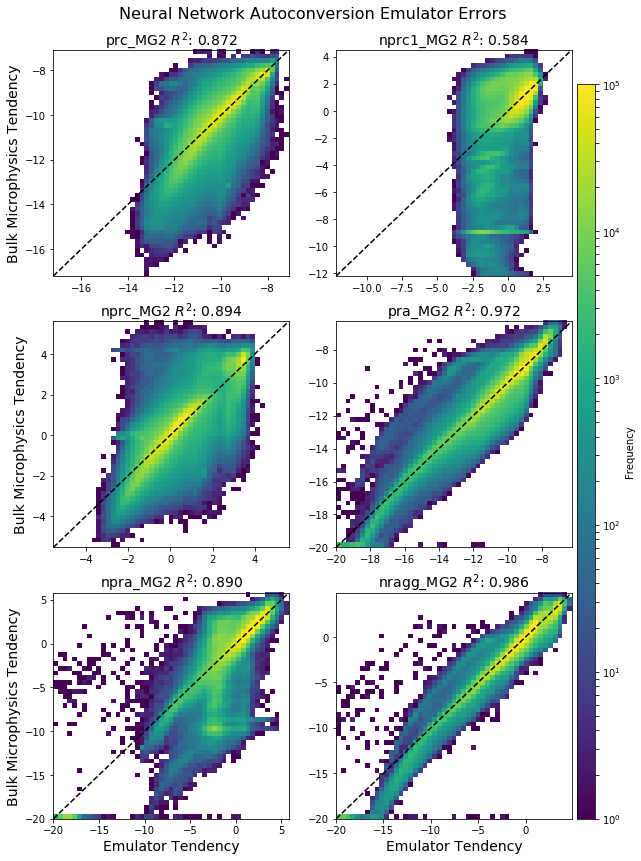

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
cax = fig.add_axes([0.96, 0.05, 0.03, 0.85])
plt.subplots_adjust(0.05, 0.05, 0.95, 0.94)
for a, ax in enumerate(axes.ravel()):
    b_min = transformed_output_val_data.iloc[:, a].min()
    b_max = transformed_output_val_data.iloc[:, a].max()
    h_obj = ax.hist2d(transformed_val_preds[:, a], transformed_output_val_data.iloc[:, a], bins=[np.linspace(b_min, b_max, 50), 
                                                                    np.linspace(b_min, b_max, 50)], cmin=1, norm=LogNorm(vmin=1, vmax=1e5))
    ax.plot(np.linspace(b_min, b_max, 10), np.linspace(b_min, b_max, 10), 'k--')
    ax.set_title(output_cols[a] + " $R^2$: {0:0.3f}".format(np.corrcoef(transformed_val_preds[:, a], 
                                                                        transformed_output_val_data.iloc[:, a])[0, 1]), fontsize=14)
    if a > 3:
        ax.set_xlabel("Emulator Tendency", fontsize=14)
    if a % 2 == 0:
        ax.set_ylabel("Bulk Microphysics Tendency", fontsize=14)
plt.colorbar(h_obj[-1], cax=cax, label="Frequency")
fig.suptitle("Neural Network Autoconversion Emulator Errors", fontsize=16,y=0.99)
plt.savefig("nn_emulator_hist_2d.png", dpi=200, bbox_inches="tight")

In [217]:
abstracts = np.array([13, 10, 7, 10, 4, 8, 3, 1, 8, 12, 6])
print(np.sum(abstracts))

82


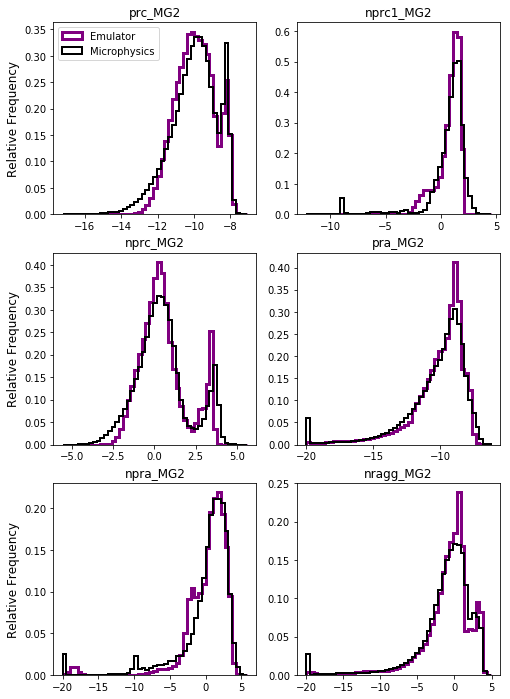

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for a, ax in enumerate(axes.ravel()):
    b_min = transformed_output_val_data.iloc[:, a].min()
    b_max = transformed_output_val_data.iloc[:, a].max()
    ax.hist(transformed_val_preds[:, a], bins=np.linspace(b_min, b_max, 50), histtype="step", density=True, 
            color="purple", linewidth=3, label="Emulator")
    ax.hist(transformed_output_val_data.iloc[:, a], bins=np.linspace(b_min, b_max, 50), histtype="step",
            density=True, color="black", linewidth=2, label="Microphysics")
    ax.set_title(output_cols[a], fontsize=12)
    #ax.set_yscale("log")
    if a == 0:
        ax.legend(loc=2)
    if a % 2 == 0:
        ax.set_ylabel("Relative Frequency", fontsize=12)
plt.savefig("nn_emulator_dists.png", dpi=200, bbox_inches="tight")

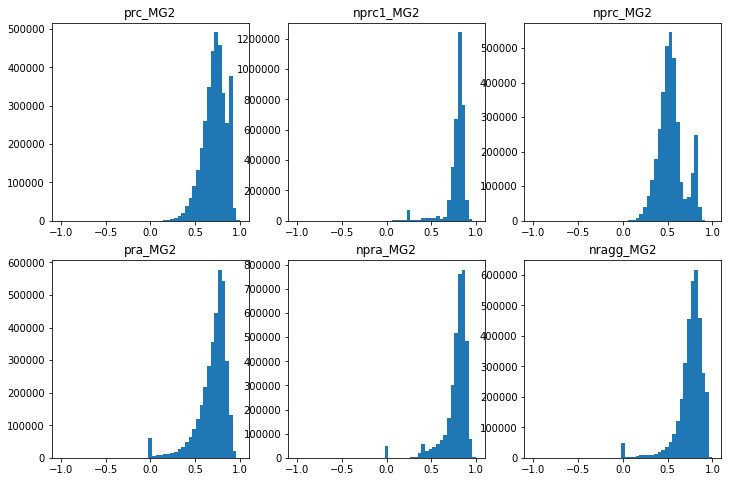

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for a, ax in enumerate(axes.ravel()):
    ax.set_title(output_cols[a])

(array([1.795323e+06, 4.253010e+05, 2.888280e+05, 2.250090e+05,
        1.853220e+05, 1.554570e+05, 1.254650e+05, 9.691700e+04,
        7.166100e+04, 5.175800e+04, 3.772600e+04, 2.692600e+04,
        1.948400e+04, 1.394900e+04, 1.005900e+04, 6.977000e+03,
        4.912000e+03, 3.448000e+03, 2.476000e+03, 1.707000e+03,
        1.241000e+03, 8.950000e+02, 7.060000e+02, 5.090000e+02,
        4.030000e+02, 2.970000e+02, 2.270000e+02, 1.950000e+02,
        1.440000e+02, 1.070000e+02, 1.200000e+02, 7.600000e+01,
        7.500000e+01, 7.100000e+01, 5.700000e+01, 4.100000e+01,
        4.000000e+01, 3.200000e+01, 2.400000e+01, 3.700000e+01,
        2.700000e+01, 2.900000e+01, 2.300000e+01, 1.600000e+01,
        8.000000e+00, 8.000000e+00, 2.400000e+01, 1.200000e+01,
        7.000000e+00, 1.000000e+01, 1.200000e+01, 1.100000e+01,
        8.000000e+00, 4.000000e+00, 3.000000e+00, 7.000000e+00,
        3.000000e+00, 2.000000e+00, 3.000000e+00, 4.000000e+00,
        5.000000e+00, 2.000000e+00, 2.00

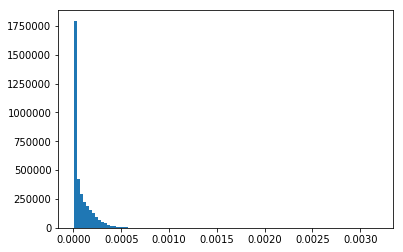

In [7]:
plt.hist(val_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1) - val_data[["prc_MG2", "pra_MG2"]].sum(axis=1), bins=100)

In [50]:
unscaled_preds = 10 ** rs_out.inverse_transform(val_preds)

In [247]:
np.sort(val_data["time"].unique())

array([  0.   ,  15.375,  30.75 ,  46.125,  61.5  ,  76.875,  92.25 ,
       107.625, 123.   , 138.375, 153.75 , 169.125, 184.5  , 199.875,
       215.25 , 230.625, 246.   , 261.375, 276.75 , 292.125, 307.5  ,
       322.875, 338.25 , 353.625])

In [51]:
lev = 32
lat = 192
lon = 288

In [52]:
out_pred_grid = np.zeros((lev, lat, lon))
out_val_grid = np.zeros((lev, lat, lon))
time = 15.375
coords = val_data.loc[val_data["time"] == time, ["depth", "row", "col"]]
out_pred_grid[coords.values[:, 0], 
              coords.values[:, 1], 
              coords.values[:,2]] = unscaled_preds[val_data["time"] == time, 3]
out_val_grid[coords.values[:, 0],
              coords.values[:, 1],
              coords.values[:,2]] = val_data.loc[val_data["time"] == time, output_cols[3]]
diff = np.log10(out_pred_grid + 1e-20) - np.log10(out_val_grid + 1e-20)

In [65]:
ds = xr.open_dataset("/Users/dgagne/data/cam_mp_files_limited/TAU_run1.cam.h1.0001-01-01-00000.nc", decode_times=False)
lon = ds.lon.values
lat = ds.lat.values
ds.close()

In [63]:
lon

array([   0.  ,    1.25,    2.5 ,    3.75,    5.  ,    6.25,    7.5 ,
          8.75,   10.  ,   11.25,   12.5 ,   13.75,   15.  ,   16.25,
         17.5 ,   18.75,   20.  ,   21.25,   22.5 ,   23.75,   25.  ,
         26.25,   27.5 ,   28.75,   30.  ,   31.25,   32.5 ,   33.75,
         35.  ,   36.25,   37.5 ,   38.75,   40.  ,   41.25,   42.5 ,
         43.75,   45.  ,   46.25,   47.5 ,   48.75,   50.  ,   51.25,
         52.5 ,   53.75,   55.  ,   56.25,   57.5 ,   58.75,   60.  ,
         61.25,   62.5 ,   63.75,   65.  ,   66.25,   67.5 ,   68.75,
         70.  ,   71.25,   72.5 ,   73.75,   75.  ,   76.25,   77.5 ,
         78.75,   80.  ,   81.25,   82.5 ,   83.75,   85.  ,   86.25,
         87.5 ,   88.75,   90.  ,   91.25,   92.5 ,   93.75,   95.  ,
         96.25,   97.5 ,   98.75,  100.  ,  101.25,  102.5 ,  103.75,
        105.  ,  106.25,  107.5 ,  108.75,  110.  ,  111.25,  112.5 ,
        113.75,  115.  ,  116.25,  117.5 ,  118.75,  120.  ,  121.25,
        122.5 ,  123

In [61]:
lon[lon > 180] = lon[lon > 180] - 360

In [74]:
bmap = Basemap(projection="robin", resolution="l", lon_0=180)
lon_grid, lat_grid = np.meshgrid(lon, lat)
x, y = bmap(lon_grid, lat_grid)

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


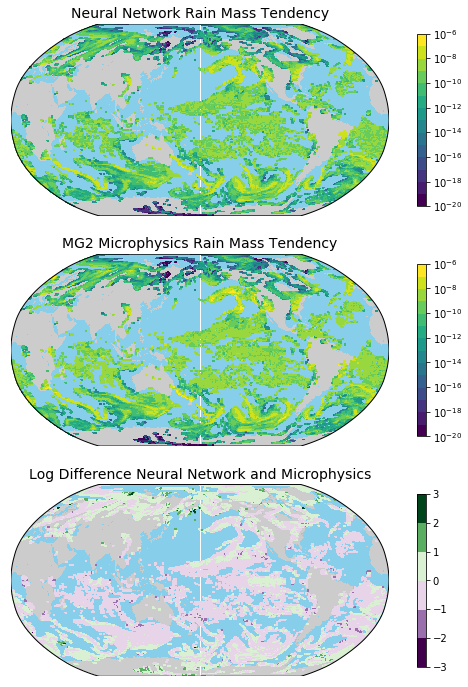

In [109]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
#bmap.drawcoastlines(ax=axes[0])
bmap.drawlsmask(ocean_color="skyblue", ax=axes[0])
bmap.drawlsmask(ocean_color="skyblue", ax=axes[1])
pred_level = -4
cobj1 = axes[0].pcolormesh(x, y, np.ma.array(out_pred_grid[pred_level], mask=out_pred_grid[pred_level]==0),
                           norm=LogNorm(vmin=1e-20, vmax=1e-6), cmap=plt.get_cmap("viridis", 14))
axes[0].set_title("Neural Network Rain Mass Tendency", fontsize=14)
cobj2 = axes[1].pcolormesh(x, y, np.ma.array(out_val_grid[pred_level], mask=out_val_grid[pred_level]==0), 
                           norm=LogNorm(vmin=1e-20, vmax=1e-6), cmap=plt.get_cmap("viridis", 14))
axes[1].set_title("MG2 Microphysics Rain Mass Tendency", fontsize=14)
bmap.drawlsmask(ocean_color="skyblue", ax=axes[2])
cobj3= axes[2].pcolormesh(x, y,np.ma.array(diff[pred_level], mask=diff[pred_level]==0), vmin=-3, vmax=3, cmap=plt.get_cmap("PRGn", 6))
axes[2].set_title("Log Difference Neural Network and Microphysics", fontsize=14)
plt.colorbar(cobj3, ax=axes[2], fraction=0.05, shrink=0.9)
plt.colorbar(cobj1, ax=axes[0], fraction=0.05, shrink=0.9)
plt.colorbar(cobj2, ax=axes[1], fraction=0.05, shrink=0.9)
plt.savefig("nn_tendency_case.png", dpi=200, bbox_inches="tight")

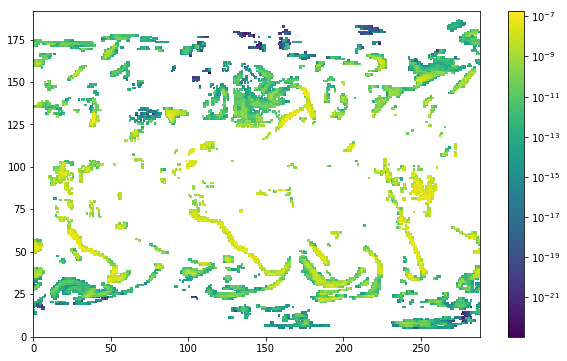

In [106]:
plt.figure(figsize=(10, 6))
plt.colorbar()

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


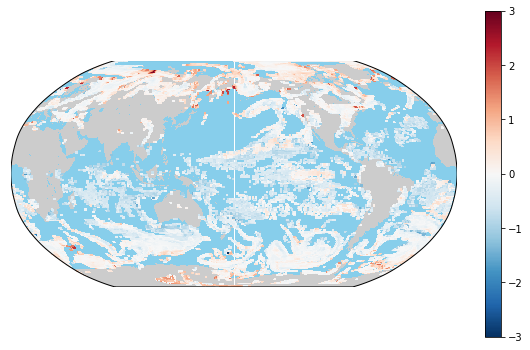

In [90]:
plt.figure(figsize=(10, 6))
bmap.drawlsmask(ocean_color="skyblue")
plt.pcolormesh(x, y,np.ma.array(diff[-4], mask=diff[-4]==0), vmin=-3, vmax=3, cmap="RdBu_r")
plt.colorbar()

In [108]:
pred_frame = pd.DataFrame(np.log10(unscaled_preds + 1e-20) 
                          - np.log10(val_data[output_cols] + 1e-20), 
                          columns=output_cols)

In [109]:
pred_frame["lev"] = val_data["lev"]

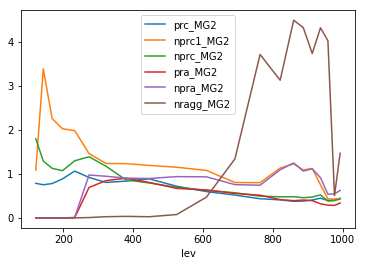

In [111]:
pred_frame.abs().groupby("lev").mean().plot()

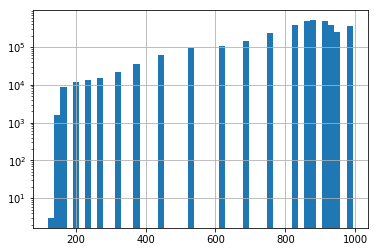

In [30]:
val_data["lev"].hist(bins=50)
plt.gca().set_yscale("log")

In [343]:
val_data.columns

Index(['Index', 'lat', 'lev', 'lon', 'P0', 'PS', 'depth', 'row', 'col', 'hyam',
       'hybm', 'pressure', 'temperature', 'RHO_CLUBB_lev', 'QC_TAU_in',
       'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in', 'prc_MG2', 'nprc1_MG2',
       'nprc_MG2', 'pra_MG2', 'npra_MG2', 'nragg_MG2', 'qctend_MG2',
       'qrtend_MG2', 'time'],
      dtype='object')

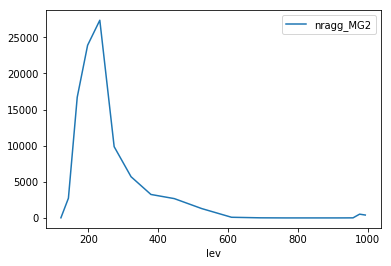

In [44]:
train_data.loc[train_data["nragg_MG2"] == 0, ["lev", "nragg_MG2"]].groupby("lev").count().plot()